TODO: 

+ Pseudocode, well-written

    + [x] Synthesize paper 

+ Get Rainfall Distributions
    + Local areas (circles)
    + Amounts over time 

+ Hydrological Cycle
    + Runoff
    + Precipitation 
    + Infiltration

# Testing
[+] a funcanim of pouring over time, and if things balance out. 
[+] 3d viz of a DEM
[+] Flowline of a point using D8, perhaps alternatives
    (then do salmon algo)
+ Is mass conserved? 

+ Time to run stuff

# Strategies 
+ Blocking Flow (high Walls : what gets flooded in turn?)

# Plotting
+ Set rcParams
+ Plot of Flow Lines: path that a block traces through the system

# Theoretical Baselines
+ Flow accumulation matrices
    + "Swimming Upstream" over gradient/slope fields
+ Maximum flow velocity (?)

In [33]:
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

import numpy as np
import sklearn.datasets as ds
from matplotlib import cm
import matplotlib.animation as animation

In [3]:
N = 5

def create_basin(N = 5):
    # Return a toy eleveation model

    # Initializations
    N = 5

    # [DEM, WaterCol, Flooded?, Direction, Slope]
    layers = 5
    grid = np.zeros((N,N,layers))

    for i in range(N):
        for j in range(N):
            # Use small scale as tally is easier for testing
            grid[i,j,0] -= 50**2*sts.norm.pdf(i, loc = N/2, scale = N) + \
                        50**2*sts.norm.pdf(j, loc = N/2, scale = N) - 500


    return grid

def create_pyramid(N = 5):
    pass

def init_grid(grid):

    grid = grid.copy()

    init_water(grid)
    init_slope(grid)
    init_directions(grid)
    
    return grid
    
basin = create_basin()
basin_grid = init_grid(basin)

np.all(basin_grid[...,1] == basin[...,1]), "Init Works Correctly"

NameError: name 'init_water' is not defined

<AxesSubplot:title={'center':'Direction (int)'}>

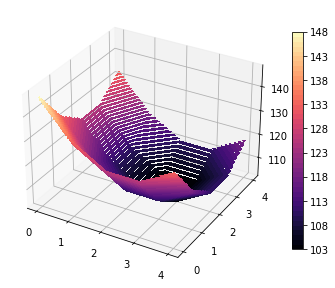

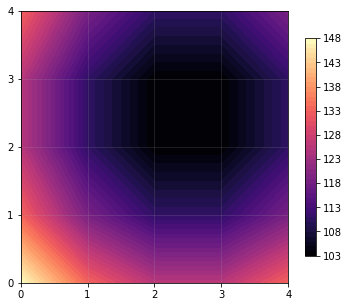

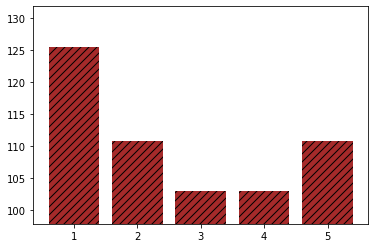

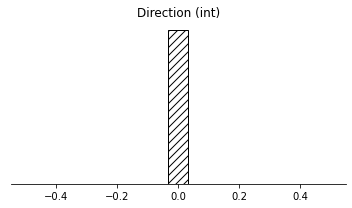

In [14]:
# Plotting Utils :: DEPRECATED

LAYER_NAMES = {
    0 : "Digital Elevation Model",
    1 : "Water Column Height (m)",
    2 : "FLOODED? (bool)",
    3 : "Direction (int)",
    4 : "Slope (degrees)"
}

def view_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1)
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50, cmap = 'magma')
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

def view_3d_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1, projection = '3d')
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50, cmap = 'magma')
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

def view_slice(grid, slice = None, ax = None):

    # Plot a bar chart of heights
    # Brown: elevation 
    # Blue: water
    if slice == None:
        slice = grid.shape[0]//2

    if ax == None:
        fig, ax = plt.subplots()

    N = grid.shape[0]
    ground    = grid[slice,:,0]
    water_col = grid[slice,:,1]

    # Plot Ground
    # plot a bar chart of heights with wave hatching
    

    ax.bar(
        x = range(1,N+1), 
        height = ground,
        hatch = '///',
        color = 'brown')

    # Plot water column
    ax.bar(
        x = range(1,N+1),
        height  = water_col,
        bottom  = ground,
        hatch = '~'
    )

    lower = 0.95*(min(ground) + min(water_col))
    upper = 1.05*(max(ground) + max(water_col))
    ax.set_ylim((lower,upper))

    # For anim
    return ax

def hist(
    grid, 
    layer = 3, 

    benchmark = None,
    ax = None,
    bins=20, 
    color='w', 
    edgecolor='k', 
    figsize=(5,3), 
    ):

    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)

    ax.hist(
        grid[...,layer].flatten(),
        bins = 15,
        color = color, 
        hatch = '///',
        edgecolor = edgecolor)

    ax.set_title(
        LAYER_NAMES[layer])

    if benchmark:
        ax.axvline(
            benchmark,
            color = 'red',
            label = f''
        )

        ax.plot(
            0,0,',',
            label = f'')
        ax.legend(loc = "upper left")

    adjust_spines(ax, ['bottom'])
    ax.set_xlabel(f'')
    
    plt.tight_layout()
    return ax
        
def adjust_spines(ax, spines, offset = 0):
        for loc, spine in ax.spines.items():
            if loc in spines:
                spine.set_position(('outward', offset))  # outward by offset points
                #spine.set_smart_bounds(True)
            else:
                spine.set_color('none')
        # turn off ticks where there is no spine
        if 'left' in spines:
            ax.yaxis.set_ticks_position('left')
        else:
            # no yaxis ticks
            ax.yaxis.set_ticks([])

        if 'bottom' in spines:
            ax.xaxis.set_ticks_position('bottom')
        else:
            # no xaxis ticks
            ax.xaxis.set_ticks([])

view_3d_layer(basin, 0)
view_layer(basin, 0)
view_slice(basin, slice = 2)
hist(basin)

In [15]:
def init_water(grid, fill = 1, test = False):
    # grid is a 1D slice
    if test:
        water_layer = grid.copy()
    # modify an existing grid
    else:
        # fill (m) water in cell perimenter
        water_layer = grid[...,1]

    water_layer[0,:], water_layer[-1,:] = fill, fill
    water_layer[:,0], water_layer[:, -1] = fill, fill

    return water_layer

directions = {
    k:v for k,v in zip(
        range(0,9), 
        [2**p for p in range(0,9)])}

def find_direction(x):
    # alias: D8 in literature. Direct flow to lowest neighbor(s)
    # If multiple, split evenly
    
    # Reject is extends beyond border
    # idx is direction
    # TODO: if none are lower, return 0
    
    center = x[4]
    x = np.where(x < center, x, float('inf'))

    idxs = np.where(x.flatten() == x.flatten().min())
    idxs = list(*idxs)

    return np.sum([directions[i] for i in idxs])

def init_directions(grid):
    # idx for elevation values
    DEM = 0
    DIRECTION = 2

    raster_kernel = np.ones((3,3))

    # TODO: better cval for constant mode
    # maybe repeat? 
    directions = generic_filter(
                    grid[...,DEM],
                    find_direction,
                    footprint = raster_kernel,  
                    mode = 'constant',
                    cval = np.nan)
    
    grid[...,DIRECTION] = directions

    return 

def calculate_slope(window, d = 1):

    # 0 1 2 3 [4] 5 6 7 8
    # 0 1 2 3     4 5 6 7

    # if central cell is nan, return nan
    if window[4] == np.nan or window[4] < 0:
        return window[4]
    
    df_dx = (np.sum(window[[2, 5, 5, 8]])  - np.sum(window[[0, 3, 3, 6]]))/8*d
    df_dy = (np.sum(window[[6, 7, 7, 8]])  - np.sum(window[[0, 1, 1, 2]]))/8*d

    rise_run = np.sqrt(df_dx**2 + df_dy**2)

    # rise/run -> value in degrees 
    # 57.29578 ~ 180/pi (acceptable precision)
    degree_slope = np.arctan(rise_run) * 57.29578

    # in degrees
    return degree_slope

def init_slope(grid, DEM = 0, slope = 1):
    # Fill out gradients (degrees) for each cell in grid
    # idx for elevation values

    # TODO: rewrite kernel to include center

    moore_kernel = np.ones((3,3))
    moore_kernel[1,1] = 1 
    
    slopes = generic_filter(
                grid[...,DEM],
                calculate_slope,
                footprint = moore_kernel,  
                mode = 'nearest',
                cval = 0)
    
    try:
        grid[...,slope] = slopes
    except:
        pass

    return slopes
    

In [26]:
# Testing
import richdem as rd
from scipy.ndimage.filters import generic_filter

# angles match package? 
# Compare existing slope calc with calc from lib
path = './media/beauford.npz'
with np.load(path) as data:
    dem = data['beauford']

dem = rd.rdarray(dem[400:800,400:800], no_data=-9999)
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')

moore_kernel = np.ones((3,3))
moore_kernel[1,1] = 1   

slopes = generic_filter(
            dem,
            calculate_slope,
            footprint = moore_kernel,  
            mode = 'nearest',
            cval = 0)

slopes_test = slopes

# Do the slope distributions match up?  

# Overlay hist of slopes and slope
slope.shape

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


(400, 400)

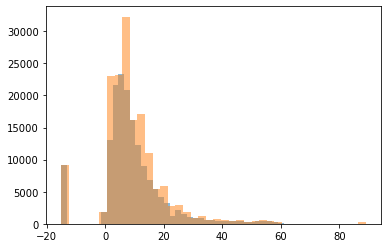

In [31]:
# 160,000
# TODO: exclude the boundaries
plt.hist(np.array(slope.flatten(), dtype = np.int8), alpha =  0.5, bins = 40)
plt.hist(np.array(slopes_test.flatten(), dtype = np.int8), alpha = 0.5, bins = 40)
plt.show()

# Assert no angles are greater than 90
assert np.sum(np.where(slopes_test > 90, 1, 0)) == 0

In [32]:
# check accuracy of slope measurement equal between two arrays
np.sum(slopes_test == slope)/slopes_test.size

# check constrained accuracy of slope measurement
np.sum(slopes_test[200:250,200:250] == slope[200:250,200:250])/slopes_test[200:250,200:250].size

<ipython-input-32-5e2e6a2f3ffa>:5: RuntimeWarning: invalid value encountered in true_divide
  np.sum(slopes_test[200:200,200:200] == slope[200:200,200:200])/slopes_test[200:20,200:20].size


rdarray(nan)

In [ ]:
# Small test cases
    # Check that flow happens predictably with flow accumulation matrix

# 1D Theoretical basis
    # % of water that should happen


In [19]:
# From main paper: see if gradient matches with paper
juraj_test = np.array(
    [
        [203.83, 201.09, 201.59, 204.31, 200.21, 201.71],
        [204.35, 203.89, 204.13, 200.29, 202.02, 200.20],
        [202.18, 201.27, 203.95, 201.20, 200.46, 201.72],
        [200.74, 202.66, 202.71, 204.34, 200.52, 201.95],
        [201.14, 204.04, 200.64, 203.18, 204.03, 204.35],
        [201.57, 203.51, 200.79, 200.01, 202.00, 202.02]
    ])

juraj_result = np.array([
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 103., 251.,   4., 254.,   0.],
       [  0.,  32., 125., 146.,   5.,   0.],
       [  0., 171.,  77., 255.,   2.,   0.],
       [  0., 255., 128., 237., 238.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]
])

# Indexed row-by-row
directions = {
    0: 1,
    1: 2,
    2: 4,
    3: 8,
    5: 16,
    6: 32, 
    7: 64, 
    8: 128}


def find_direction(x, method  = 'Dinf'):
    # alias: Dinf in literature. Direct flow to lowest neighbor(s)
    # If multiple, split evenly
    
    # filter uses flat arrays
    center = x[4]
    lower_cells = np.where(x < center, x, float('inf'))

    #idxs = np.where(x == narrow.min())
    #idxs = list(*idxs)
    
    idxs = np.where(lower_cells < float('inf'))
    idxs = list(*idxs)
    
    return np.sum([directions[i] for i in idxs])

def init_direction(grid):
    # idx for elevation values
    moore_kernel = np.ones((3,3)) 
    
    # TODO: better cval for constant mode
    # maybe repeat? 
    directions = generic_filter(
                    grid,
                    find_direction,
                    footprint = moore_kernel,  
                    mode = 'constant',
                    cval = np.nan)

    # Set border of directions to 0
    directions[0,:] = 0
    directions[:,0] = 0
    directions[-1,:] = 0
    directions[:,-1] = 0
    
    return directions

# Are direction calculations correct for all cells?
assert init_direction(juraj_test).all() == juraj_result.all()

In [21]:
# GOAL: Check that flow happens predictably
def generate_flow_acc(dir_grid, n_iters = 10000, max_visits = 5):

    # Take a direction grid and generate flow accumulation grid

    N = dir_grid.shape[0]
    # Init flow accumulation matrix
    flow_acc = np.zeros((N,N))

    for i in range(n_iters):

        # pick a random cell
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)

        curr_cell = [x,y]
    
        lim = 0
        while lim < max_visits:

            i,j  = curr_cell[0], curr_cell[1]
            direction = int(dir_grid[i,j])
            # Get directions of flow
            dir_keys = get_direction_keys(direction)

            if dir_keys:
                # performance: choose a neighbor to flow to first
                key_idx = np.random.choice(len(dir_keys))
                key = dir_keys[key_idx]
                dx, dy = get_direction_idxs(key)

                downstream_neighbor = [i+dx, j+dy]

                curr_cell = downstream_neighbor
                flow_acc[curr_cell[0], curr_cell[1]] += 1
                lim += 1
            else:
                # reached boundary/outlet, break
                break 

    return flow_acc


generate_flow_acc(juraj_result)

array([[ 121.,  145.,  169.,    0., 1324.,   52.],
       [   0.,  317.,  177., 1072.,   47.,  499.],
       [ 248.,  557., 1194.,  839.,  608.,    0.],
       [ 238.,  462.,  347.,  404.,  202.,   60.],
       [  82.,  347.,  229.,  147.,   72.,   53.],
       [  77.,   84.,  571.,  156.,   62.,    0.]])

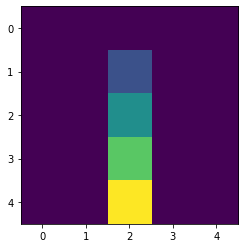

In [22]:
# A 5x5 grid, with 3rd column of 128
down_stream = np.zeros((5,5))
down_stream[0:4,2] = 128

plt.imshow(generate_flow_acc(down_stream, n_iters = 100000, max_visits = 10))


In [12]:
# Penrose Staircase
penrose = np.zeros((5,5))

# TODO: cast direction to arrows

# transform ij indexing to cartesian xy
def ij_to_xy(i, j):
    return (j, -i)

# do a quiver plot of direction grid

penrose[1,1:4] = 2**5
penrose[1:4,3] = 2**7
penrose[3,1:4] = 2**3
penrose[2:4,1] = 2

p = generate_flow_acc(penrose, n_iters = 20000, max_visits = 10)

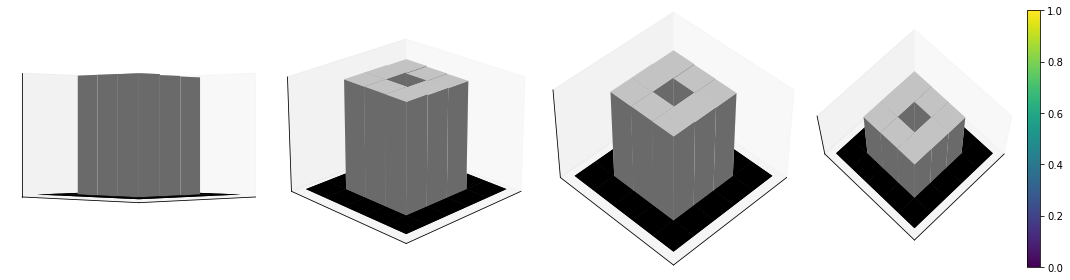

In [25]:
a = orbit_dem(p)

In [ ]:
# where its 0, [0,0] else project the direction onto the xy plane

In [8]:
def get_direction_keys(num):
    # get direction key(s) of lowest neighbor(s)
    binary = np.binary_repr(num, width=8)
    # invert binary convert to list
    binary = list(map(int, binary[::-1]))
    # find all 1s
    indices = np.where(np.array(binary) == 1)

    return list(indices[0]) if len(indices[0]) > 0 else None

def get_direction_idxs(key):
    # unpack ij_dict to displacement indices
    return ij_dict[key][0], ij_dict[key][1]


get_direction_keys(128)


[7]

In [30]:
def make_direction_dict():
        # 3x3 array 0 to 8
    i = np.array([-1,-1,-1, 0, 0, 0, 1, 1, 1])
    j = np.array([-1, 0, 1,-1, 0, 1,-1, 0, 1])

    # stack i and j
    ij = np.stack((i,j), axis = 1)

    # save each row as value in dict
    ij_dict = {k:list(v) for k,v in enumerate(ij)}

    return ij_dict


ij_dict = make_direction_dict()

In [34]:
#### Update Rules

# liquid loss = inflitration
depth = np.linspace(0,10,100)
s = np.linspace(0,90,100)
n = 0.2
w = 10

# Flow rate 
def fluid_velocity(depth = 4, s=np.pi, n = 0.2):
    """Params
        cell  (array[4]): a sim cell
        depth[m]   (int): depth of water column at cell
        s[deg]   (float): slope of cell
        n        (float): Manning roughness coefficient."""

    #depth = cell[0] 
    #s     = cell[2] 

    return np.cbrt(depth**2)*np.sqrt(s) / n


def time_through_cell(cell, width = 10):
    """Params
        v    (float): calculated fluid_velocity through cell
        width  (int): width of cell/raster resolution"""

    v = fluid_velocity(cell)

    return width/v

# What is this referring to
def volume_entering_cell(depth, width, v, t = 1):
    return depth * width * v * t

# Meet flooding conditions
def is_flooded(cell, t = 1):
    """check if cell is flooded
    Params
    Returns
        flooded? (bool)"""
    return time_through_cell(cell) > t


def infiltration_velocity(Ks = 2, Hf = 1, F = 2, Md = 3):
    """
    Params
        Ks(mmh^-1) : hydraulic conductivity
        Hf(mm)     : suction lift
        Md(mm)     : soil moisture deficit
        F          : total depth of infiltration
    """
    # How fast water seeps into the soil
    # infiltration_velocity << fluid_velocity
    return Ks*(1 + Hf*Md/F)

    

Text(0, 0.5, 'Fluid Velocity (m/s)')

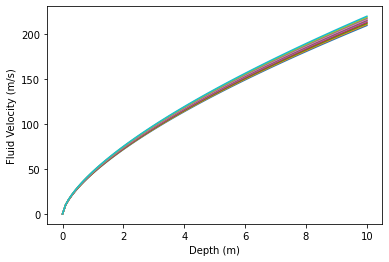

In [35]:
fv = np.vectorize(fluid_velocity)

for angle in s[-10:]:
    plt.plot(depth, fv(depth=depth, s = angle))
# Add labels
plt.xlabel('Depth (m)')
plt.ylabel('Fluid Velocity (m/s)')


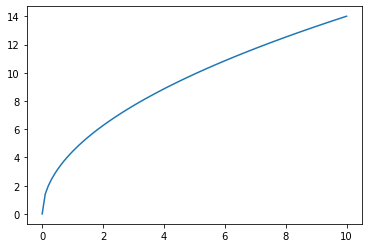

In [22]:
# Maximum theoretical flow
def compute_max_flow(h):
    # Energy is conserved
    g = 9.81
    v = np.sqrt(2*g*h)
    return v

# for different heights, plot max flow
h  = np.linspace(0,10,100)
plt.plot(h, compute_max_flow(h))


# References
+ Working with Rasters
    + https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/
    +https://rasterio.readthedocs.io/en/latest/topics/reproject.html
+ Flow Methods
    + https://richdem.readthedocs.io/en/latest/flow_metrics.html

+ Slope Calculation 
    + Horn paper
    +  https://geol260.academic.wlu.edu/course-notes/digital-terrain-analyses/digital-terrain-analysis-3/
    + Barnes, Richard. 2016. RichDEM: Terrain Analysis Software. http://github.com/r-barnes/richdem




+ Second paper, includes rainfall stuff.
+ Calculating the direction of flow is hard.
    + Start: minimum energy principle, choose the direction corresponding to the maximum slope (ie lowest cell in neighborhood)
        + However, "singularities due to finite resolution" at pits (where all 8 cells share the same height)  or flat zones (sequences of cells with same elevation)
        + CA2CHYM better than D8
        + smooths DEM (heights)
            x += sum(neighbors)/sum(distances = r)


The WCA2D model is a diffusive-like model that **ignores inertia terms and momentum conservation**. It is designed to be as fast as possible for large-scale cachements.

+ The ratios of water transferred from the central cell to thedownstream neighbour cells (intercellular-volume) are calculated using a quick weight-based system
+ The volume of water transferred between the central cell andthe neighbour cells is limited by the Manning's formula and the critical flow equation
+ Both the **adaptive time step** and the velocity are evaluatedwithin a larger updated time step to speed up the simulation.


Rank
    + Sort cell water levels in neighborhood
    + Lower ranked cells are receivers of water from cell
        + lower cell **fills** first
            Fill lowest until second lowest fills
            + fill these until they reach the level of the third
            + until no water is lift to transfer or height is reached. 

+ Improve:
    + identify downstream cells (lower water level than central cell)
        + Less than tau, ignore. If greater than tau, will receive. 
        + calc volume differences (area * height difference)
        + eval min, max and total volume differences. 
            + Volume diference = availabe storage volume (space in neighbor that can receive water from central cell)
            
    + compute weigt of each downstream cell based on ** available storage volume. **
        + if the cell is a receiver, it is the volume of water that can be stored in the cell
            + difference between central cell and receiver cell
    + compute total amoutnt that will leave centrall cell. 
    + for each downstream cell, set the eventualintercellular-volume which depends on the previously computedweight and total amount of volume transferred

+ Prone to oscillation?

In [24]:


digits = ds.load_digits()['data']


def plot_dem(dem, rotation = 30,  cmap = 'binary', ax = None):
    # A function that plots a DEM in 3d

    bins = dem.shape[0]
    dem = dem.flatten()

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    hist, xedges, yedges = np.histogram2d(dem, dem, bins=bins, range=[[0, bins], [0, bins]])

    # Figure out anchors for each bar
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for each bar
    dx = dy = 1 * np.ones_like(zpos)
    dz = dem

    cmap = cm.get_cmap(cmap) # discrete colormap
    max_height = np.max(dz)   # max height
    min_height = np.min(dz)    
    # normalize each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    lc = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = rgba, zsort='average')

    # show from side
    ax.view_init(elev=rotation, azim=45)
    # remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    return lc


# A function that plots a DEM heightmap in 4 angles
def orbit_dem(dem, n = 4, cmap = 'Greys_r'):
    # Plot a DEM from different n angles
    # init 3d subplots
    # A figure with a grid of subplots, no margin
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = fig.add_subplot(n, 4, i+1, projection='3d')
        rot = 90 * i/n
        lc = plot_dem(dem, rot, cmap, ax)

    # Make layout compact
    fig.colorbar(lc, ax = ax, shrink = 1)
    fig.tight_layout()

    return fig


# TODO: overlay water layer, stacked 3d bar


MovieWriter imagemagick unavailable; using Pillow instead.


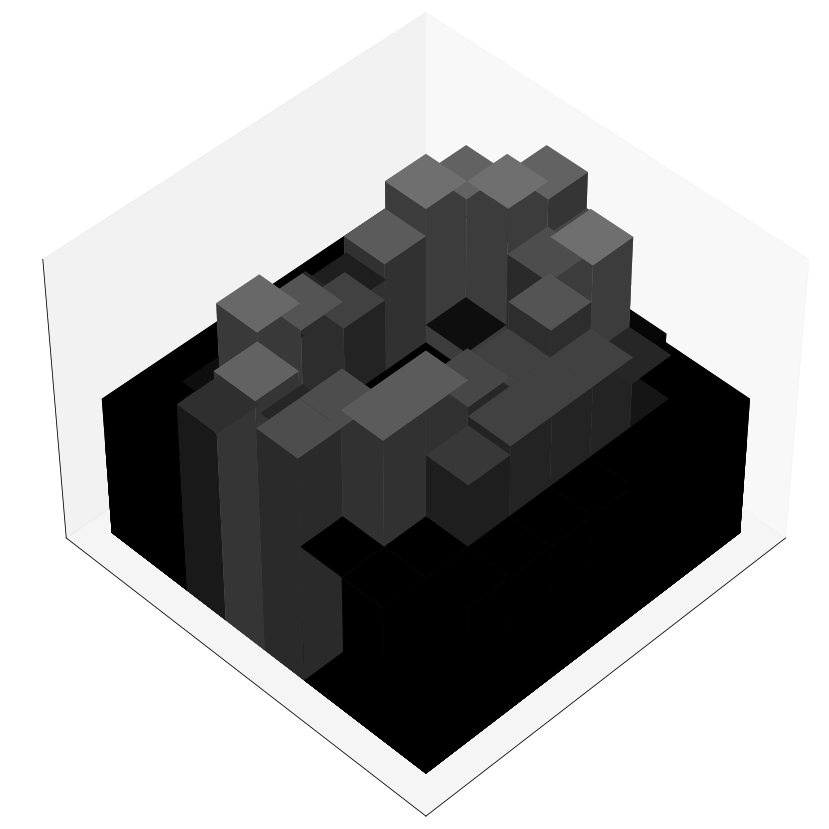

In [189]:

# Create an animation using FuncAnimation 
def animate_digits_animation(digits, n = 4, cmap = 'Greys_r'):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    def update(i):
        digit = digits[0] + (1 + i*5)
        rot = 45
    
        plot_dem(digit.reshape(8,8), rot, cmap, ax)

    anim = animation.FuncAnimation(fig, update, frames=n, interval=200)

    return anim

test = animate_digits_animation(digits)
test.save('digits.gif', writer='imagemagick', fps=10)

Hi Prof, 

So I worked through the first paper in detail again today, and I realized while replicating things that a lot of things are fishy and/or incomplete. 
1. The paper suggests that it uses the D8 model for flow direction (pick the **D**irection of the **8** neighbors with the lowest elevation). However, when I replicated Figure 3 in the paper, I found that it was instead doing a "pick the sum of the directions of all lowest neighbors" technique, which I haven't seen in similar papers. 
2. There was a miscalculation in the slope field. I corrected this and tested my calculations against a DEM-manipulation package, and got exactly the same results. 
3. Nonetheless, I have so much concern about the update rules and how they are defined. Each iteration, and each cell, the water in the cell changes by (water in from neighbors [to whom the central cell is the D8 neighbor]) - (water out to D8 neighbor). There is an idea about transfers happening in 'active cells' in the control flow diagram, but there is no mention of what makes a cell active in the rest of the paper. 
4. I don't understand how things are reconciled, in terms of flooded cells. 